In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import operator

from sklearn.metrics import r2_score, mean_squared_error, make_scorer

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import ElasticNetCV

# To install: conda install py-xgboost
import xgboost as xgb

In [2]:
# Adjust screen output size
#pd.util.terminal.get_terminal_size() # get current size
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)

### Dataset 6 with: ratio RGB data, dummy Google Places & Amenities Data, drop text processing

In [3]:
data6 = pd.read_csv('data_test6.csv', index_col=0)
# get train portion
train6 = data6[data6['dataset']=='train']
# drop id, dataset
train6 = train6.drop(['id', 'dataset'], axis=1)
train6.isnull().sum() # None missing

In [6]:
# Split out predictors from target
y_data6 = train6['log_price']
x_data6 = train6.drop(['log_price'], axis=1)
# Split into training and test sets
x_train6, x_test6, y_train6, y_test6 = train_test_split(x_data6, y_data6, test_size=0.26, random_state=11)

##### Elastic Net

In [7]:
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)

elasticNet.fit(x_train6, y_train6)
y_test_elas = elasticNet.predict(x_test6)

In [8]:
# What is r2 score?
r2_score(y_test6, y_test_elas)

0.63326431173849917

In [9]:
math.sqrt(mean_squared_error(y_test6, y_test_elas))

0.4353136604327891

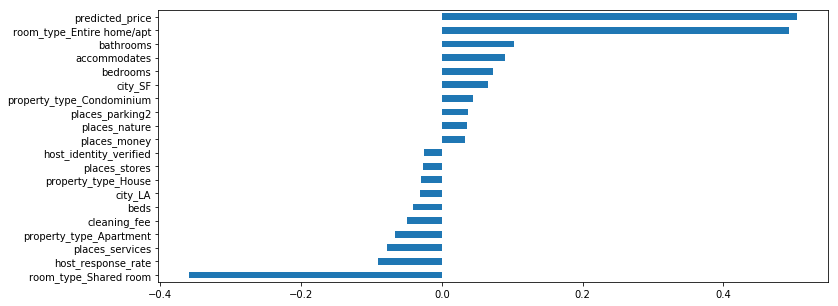

In [11]:
# What are the important coefficients?
plt.figure(figsize=(12,5))
coefs_elas = pd.Series(elasticNet.coef_, index=x_train6.columns)
import_coefs_elas = pd.concat([coefs_elas.sort_values().head(10), coefs_elas.sort_values().tail(10)])
import_coefs_elas.plot(kind='barh')

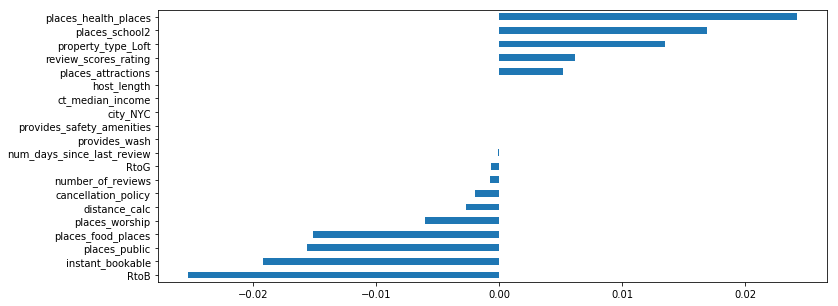

In [12]:
# What about the next 10 coefficients?
plt.figure(figsize=(12,5))
coefs_elas = pd.Series(elasticNet.coef_, index=x_train6.columns)
import_coefs_elas = pd.concat([coefs_elas.sort_values()[10:20], coefs_elas.sort_values()[-20:-10]])
import_coefs_elas.plot(kind='barh')

In [13]:
# What were the dropped vars?
print("Elastic Net picked " + str(sum(coefs_elas != 0)) + " features and eliminated the other " +  \
      str(sum(coefs_elas == 0)) + " features")

Elastic Net picked 37 features and eliminated the other 39 features


In [14]:
# What were the features dropped
coefs_elas[coefs_elas==0]

host_has_profile_pic         -0.0
GtoB                         -0.0
places_airport2               0.0
places_hotels                -0.0
places_stations              -0.0
places_cemetery2             -0.0
provides_heat_cool            0.0
provides_wash                 0.0
provides_small_accessories    0.0
provides_large_accessories    0.0
provides_safety_amenities     0.0
provides_baby_amenities       0.0
provides_bath_amenities       0.0
provides_accessible           0.0
provides_beach                0.0
provides_meal                 0.0
provides_internet_connect     0.0
provides_television           0.0
provides_animals              0.0
provides_doorman_greet        0.0
provides_parking_by_rental    0.0
provides_other_amenities      0.0
provides_privacy_amenity      0.0
provides_smoking_allowed      0.0
provides_good_navigate        0.0
property_type_Guesthouse      0.0
property_type_Other          -0.0
property_type_Other2         -0.0
property_type_Townhouse      -0.0
room_type_Priv

##### XGBoost Regressor

In [17]:
dtrain = xgb.DMatrix(x_train6, y_train6)
dtest = xgb.DMatrix(x_test6)

xgb_params = {
    'eta': 0.037,
    'max_depth': 10,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'lambda': 0.8,   
    'alpha': 0.4, 
    'base_score': np.mean(y_train6),
    'silent': 0
}

model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=242)

In [19]:
print('RMSE:', mean_squared_error(model.predict(dtrain), y_train6)**(1/2))

RMSE: 0.262308277536


In [20]:
importance = model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)

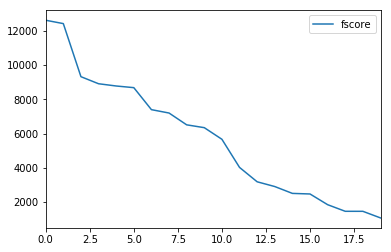

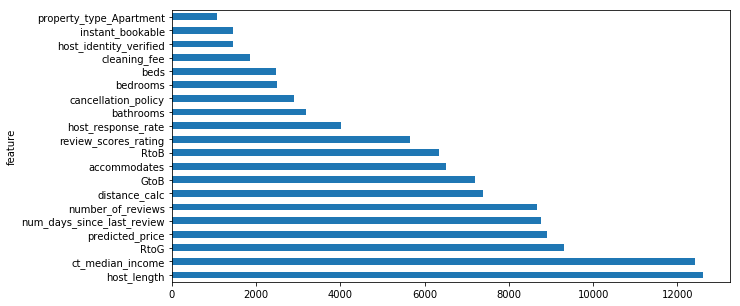

In [21]:
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
# plot top 100 features 
plt.figure()
df.head(20).plot()
df.head(20).plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 5))